# Sankey Diagram by Similarity Scores


### Import Libs

In [1]:
import os
print('env name:',os.environ['CONDA_DEFAULT_ENV'])

import plotly.graph_objects as go
from skimage import io
import urllib, json
import pandas as pd
import numpy as np
from sciosci.assets import advanced_assets as aa
from tqdm import tqdm
import re

env name: sciosci


### Initialize

In [28]:
random_link_colors = False
multi_year_similarity = True

comment = ''
clustering_method = 'agglomerative ward '
link_strength_threshold = 0.975
link_strength_threshold_2 = 0.985
power = 1 # value power for increasing the differences 

#### Separated years

In [17]:
last_period_start = "2017"
data_type = "Author Keywords - Abstract Words "
label_source = ''
year_periods_topics = ["8","8","12","12","16","16"]  #["7","7","9","13","13","17"]  
# Sorted periods' topic numbers from new to old from left to right
year_periods = ["1990-2004","2005-2007","2008-2010","2011-2013","2014-2016","2017-2018"] 
# Sorted year periods from new to old from left to right
data_directory = '/home/sahand/GoogleDrive/Data/Word Clustering/50D/'

#### cumulative years

In [ ]:
last_period_start = "1990"
data_type = "Author Keywords - Cumulative"
year_periods_topics = ["7","8","10","10","10","11"]  
# Sorted periods' topic numbers from new to old from left to right
year_periods = ["1990-2004","1990-2007","1990-2010","1990-2013","1990-2016","1990-2018"] 
# Sorted year periods from new to old from left to right
data_directory = 'data/clusters/FastText/15D/10 dim/'

#### cumulative documents

In [ ]:
last_period_start = "1990"
label_source = 'topics/'#authkeyword/'
data_type = "Abstracts+Titles - Cumulative"
year_periods_topics = ["9","10","11","14","15","15"]
# Sorted periods' topic numbers from new to old from left to right
year_periods = ["1990-2004","1990-2007","1990-2010","1990-2013","1990-2016","1990-2018"] 
# Sorted year periods from new to old from left to right
data_directory = '/home/sahand/GoogleDrive/Data/FastText doc clusters - SIP/50D/'
#'data/clusters/FastText/50D/'

#### Separated documents

In [4]:
last_period_start = "2017"
label_source = ''#authkeyword/'
data_type = "Abstracts+Titles - Separated"
year_periods_topics = ["10","8","9","11","11","11"]
# Sorted periods' topic numbers from new to old from left to right
year_periods = ["1990-2004","2005-2007","2008-2010","2011-2013","2014-2016","2017-2019"] 
# Sorted year periods from new to old from left to right
data_directory = '/home/sahand/GoogleDrive/Data/Document Clustering/50D 4k/'
#'data/clusters/FastText/50D/'

### Read & Prepare Data

Generate nodes and links

Node colors are:


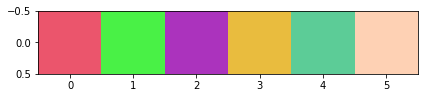

In [11]:
node_colors_palette = aa.color_palette_maker(len(year_periods_topics),alpha=0.8)
node_colors = ['rgba('+str(x).replace('[','').replace(']','')+')' for x in node_colors_palette]
link_colors = [x[:-4]+'0.4)' for x in node_colors]
node_colors_palette = np.array([node_colors_palette])
print("Node colors are:")
io.imshow(node_colors_palette)
labels_numeric_dict = {per:[] for per in year_periods}


In [12]:
def color_alternator(rgba_colors,up_thresh = 0.8, down_thresh = 0.2, color_part = 2):
    new_colors = []
    color_s = rgba_colors[0].split(', ')
    cell = float(rgba_colors[0].split(', ')[color_part])
    if cell > 0.5:
        portion = (cell-down_thresh)/len(rgba_colors)
    else:
        portion = (up_thresh-cell)/len(rgba_colors)

    for idx,color in enumerate(topic_colors):
        if cell > 0.5:
            new_cell = cell-(idx+1)*portion
        else:
            new_cell = cell+(idx+1)*portion

        color_s[color_part] = str(new_cell)
        new_colors.append(', '.join(color_s))
    return new_colors

### Process

#### Multi year similarity

In [13]:
# Give unique ID to all clusters
total = 0
cluster_ids = []
for period_index, period in enumerate(year_periods):
    cluster_ids.append(list(range(total,int(year_periods_topics[period_index])+total)))
    total = total + int(year_periods_topics[period_index])
cluster_ids

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17],
 [18, 19, 20, 21, 22, 23, 24, 25, 26],
 [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37],
 [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
 [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]

In [40]:
labels_all = []
labels_all_numeric = []
labels_all_numeric_sequential = []
colors_all = []
colors_all_links = []

similarity_source = []
similarity_target = []
similarity_value = []

if multi_year_similarity is True:
    for period_index, period in enumerate(year_periods):
        print(period,year_periods_topics[period_index],cluster_ids[period_index][0])

        terms = pd.read_csv(data_directory+'term_cluster-tables/'+label_source+period+" "+year_periods_topics[period_index]+" - term_cluster.csv").fillna('')
        scores = pd.read_csv(data_directory+'term_cluster-tables/'+label_source+period+" "+year_periods_topics[period_index]+" - term_score.csv").fillna(0)


        labels_this_period = aa.topic_label_maker(terms,scores,ratio=10, prefix=period.split('-')[1][-2:]+' - ',limit=5)
#         labels_this_period = list(range(len(cluster_ids[period_index])))
#         labels_this_period = [period+' - '+str(x) for x in labels_this_period]
        
        labels_all = labels_all + labels_this_period
        labels_all_numeric = labels_all_numeric + [str(x) for x in list(range(0,len(labels_this_period)))]
        
        topic_colors = [node_colors[period_index]] * len(labels_this_period)
        topic_colors = color_alternator(topic_colors,up_thresh = 0.99, down_thresh = 0.01, color_part = 2)
        colors_all = colors_all + topic_colors
        
        topic_link_colors = [link_colors[period_index]] * len(labels_this_period)
        topic_link_colors = color_alternator(topic_link_colors,up_thresh = 0.99, down_thresh = 0.01, color_part = 2)
        colors_all_links = colors_all_links + topic_link_colors
        
    #    similarity_scores = None
        if period_index < len(year_periods) - 1:
            similarity_scores = pd.read_csv(data_directory+'similarity/'+clustering_method+year_periods[period_index]+"_"+year_periods_topics[period_index]+"-"+year_periods[period_index+1]+"_"+year_periods_topics[period_index+1]+".csv")
    #        terms_previous_period = pd.read_csv(data_directory+"cumulative/"+year_periods[period_index+1]+"_"+year_periods_topics[period_index+1]+"/top_99-percentile_keywords_terms-spaced.csv")

            # flatten the similarity scores
            for period_cluster_no,row in similarity_scores.iterrows(): # repeat to n_clusters of A

                elem_num = len(row.values.tolist()) # number of columns in similarity file
                for idx in range(1,elem_num,2):     # repeat to n_clusters of B
                    if row.values.tolist()[idx+1]**power > link_strength_threshold:
                        similarity_source.append(int(row.values.tolist()[0]) + cluster_ids[period_index][0])
                        similarity_target.append(int(row.values.tolist()[idx]) + cluster_ids[period_index+1][0])
                        similarity_value.append(row.values.tolist()[idx+1]**power)
                
        if period_index < len(year_periods) - 2:
            try:
                similarity_scores = pd.read_csv(data_directory+'similarity/'+clustering_method+year_periods[period_index]+"_"+year_periods_topics[period_index]+"-"+year_periods[period_index+2]+"_"+year_periods_topics[period_index+2]+".csv")
    #        terms_previous_period = pd.read_csv(data_directory+"cumulative/"+year_periods[period_index+1]+"_"+year_periods_topics[period_index+1]+"/top_99-percentile_keywords_terms-spaced.csv")
            except:
                print("\nThere is no similarity record at ",data_directory+'similarity/'+clustering_method+year_periods[period_index]+"_"+year_periods_topics[period_index]+"-"+year_periods[period_index+2]+"_"+year_periods_topics[period_index+2]+".csv")
                similarity_scores = None
                continue
                
            for period_cluster_no,row in similarity_scores.iterrows(): # repeat to n_clusters of A

                elem_num = len(row.values.tolist()) # number of columns in similarity file
                for idx in range(1,elem_num,2):     # repeat to n_clusters of B
                    if row.values.tolist()[idx+1]**power > link_strength_threshold_2:
                        similarity_source.append(int(row.values.tolist()[0]) + cluster_ids[period_index][0])
                        similarity_target.append(int(row.values.tolist()[idx]) + cluster_ids[period_index+2][0])
                        similarity_value.append(row.values.tolist()[idx+1]**power)
                
                
    labels_all_numeric_sequential = [str(x) for x in list(range(0,len(labels_all_numeric)))]

100%|██████████| 11/11 [00:00<00:00, 2719.08it/s]

1990-2004 10 0
2005-2007 8 10
2008-2010 9 18
2011-2013 11 27
2014-2016 11 38
2017-2019 11 49


### Draw

#### Prepare links

* For clustered colors:

In [41]:
if random_link_colors is False:
    final_colors_links = [colors_all_links[x] for x in similarity_source] # in similarity_source]
    final_color_links_varied = []
    for i,value in tqdm(enumerate(similarity_value),total=len(similarity_value)):
        final_color_links_varied.append(final_colors_links[i].replace(', 0.4',', '+str(value/2)))
#         print(final_color_links_varied[i])
    final_colors_links = final_color_links_varied

100%|██████████| 86/86 [00:00<00:00, 111158.75it/s]


* For random colors:

In [42]:
if random_link_colors is True:
    final_colors_links = ['rgba('+str(x).replace('[','').replace(']','')+')' for x in aa.color_palette_maker(len(similarity_target),alpha=0.3)]

#### Prepare labels

In [43]:
labels_all_new = []
for label in tqdm(labels_all):
    label_to_split = label.split('- ')
    label_split = label_to_split[1].split(', ')
    label_split_new = []
    for split in label_split:
        if len(split)>20:
            label_split_new.append(aa.abbreviator(split))
        else:
            label_split_new.append(split)
    labels_all_new.append(label_to_split[0]+'- '+', '.join(label_split_new))
labels_all_new = [label.replace('computer science','cs').replace('engineering','en') for label in labels_all_new]

100%|██████████| 60/60 [00:00<00:00, 95037.10it/s]


#### Draw

In [45]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 10,
      line = dict(color = "black", width = 0),
      label = labels_all,
      color = colors_all #"blue"
    ),
    link = dict(
      source = similarity_source,# 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = similarity_target,# 3, 3, 4, 4, 5],
      value = similarity_value,# 4, 2, 8, 4, 2],
      color = final_colors_links #"grey"
  ))])

fig.update_layout(title_text="H-Clustering -"+data_type+" Development of fields: Docs 1990-2004 to "+last_period_start+"-2019 : Enhanced number of clusters  - pow "+str(power)+" - thresh "+str(link_strength_threshold), font_size=11)
fig.update_layout(
    autosize=False,
    width=1500,
    height=900)
fig.show()